In [1]:
import torch
import pickle
import numpy as np
from skimage import io
import copy
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
 
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
 
from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler
 
from matplotlib import colors, pyplot as plt
%matplotlib inline
 
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
np.random.seed(77)
torch.manual_seed(77)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
#What GPU we have from Google
!nvidia-smi

Tue Jun 29 17:02:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Helper Functions (Losses и Accurancy)

In [13]:
import pickle

def save_dict_to_file(my_dict, file_path):
    with open(file_path, 'wb') as handle:
        pickle.dump(my_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_dict_from_file(file_path):
    with open(file_path, 'rb') as handle:
        unserialized_data = pickle.load(handle)
        
    return unserialized_data

def save_model(path, model, losses, acc, best_model_wts):
    torch.save(model.state_dict(), path + '.pth')
    torch.save(best_model_wts, path + '_best_w.pth')
    save_dict_to_file(losses, path + '_losses.pickle')
    save_dict_to_file(acc, path + '_acc.pickle') 

### Helper Function For Neural Network Trainig

In [14]:
from tqdm import tqdm_notebook
import time
import logging

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,
                scheduler=None, use_gpu=True, best_acc=None, best_loss=None,
                flag_save_wts_to_file = False, path = None, losses=None, 
                acc=None):
    since = time.time()

    if flag_save_wts_to_file:
        if path is None:
            raise ValueError('Вы хотетите сохранять веса, но не задали путь в переменную path!')
        else:
            print('Logging...')
            logging.basicConfig(level=logging.INFO, filemode='w', filename=path + '_log_file.txt')
            logger = logging.getLogger(__name__)

    best_model_wts = copy.deepcopy(model.state_dict())
    epoch_best_acc = 0
    best_loss_model_wts = copy.deepcopy(model.state_dict())
    epoch_best_loss = 0
    
    if best_acc is None:
        best_acc = 0.0

    if best_loss is None:
        best_loss = np.inf
    
    if losses is None and acc is None:
        losses = {'train': [], 'val': [], 'best':[]}
        acc = {'train': [], 'val': [], 'best':[]}
    
    for epoch in tqdm_notebook(range(num_epochs)):
        if scheduler is None:
            lr_epoch = []
            # выводим lr для каждой группы слоев которую мы определили
            # если мы используем один lr для всех обучаемых слоев выведет его
            for param_group in optimizer.param_groups:
                lr_epoch.append(param_group["lr"])
        else:
            lr_epoch = scheduler.get_lr()
            
        print(f'Epoch {epoch}/{num_epochs - 1} lr={lr_epoch}')
        print('-' * 10)

        if flag_save_wts_to_file:
            logger.info(f'Epoch {epoch}/{num_epochs - 1} lr={lr_epoch}')
            logger.info('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # установаить модель в режим обучения
            else:
                model.eval()  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for inputs, labels in dataloaders[phase]:
                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # активируем расчет градиентов для фазы обучения
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # сделаем backward шаг оптимизатора если сейчас фаза обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # подсчитаем статистику по эпохе
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc = epoch_acc.item()
            
            losses[phase].append(epoch_loss)
            acc[phase].append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if flag_save_wts_to_file:
                logger.info('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # если на валидационной выборке удалось получить лучшую,
            # чем ранее точность, то запомним веса модели в best_model_wts
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epoch_best_acc = epoch
                print(f'\n***new best wts with acc {best_acc} at {epoch_best_acc} epoh***')
                if flag_save_wts_to_file:
                    torch.save(best_model_wts, path + '_best_w.pth')
                    logger.info(f'save new best wts with acc {best_acc} at {epoch_best_acc} epoh')
                acc['best'] = [epoch_best_acc, best_acc]
            
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_loss_model_wts = copy.deepcopy(model.state_dict())
                epoch_best_loss = epoch
                print(f'\n***new best wts with loss {best_loss} at {epoch_best_loss} epoh***')
                if flag_save_wts_to_file:
                    torch.save(best_loss_model_wts, path + '_best_w_loss.pth')
                    logger.info(f'save new best wts with loss {best_loss} at {epoch_best_loss} epoh')
                losses['best'] = [epoch_best_loss, best_loss]

        if flag_save_wts_to_file:
            print(f'*** save model wts at this {epoch} epoch ! *** \n')
            torch.save(model.state_dict(), path + '.pth')
            save_dict_to_file(losses, path + '_losses.pickle')
            save_dict_to_file(acc, path + '_acc.pickle')
            logger.info(f'*** save model wts at this {epoch} epoch ! *** \n')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} at {}'.format(best_acc, epoch_best_acc))
    print('Best val Loss: {:4f} at {}'.format(best_loss, epoch_best_loss))

    if flag_save_wts_to_file:
        logger.info('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        logger.info('Best val Acc: {:4f} at {}'.format(best_acc, epoch_best_acc))
        logger.info('Best val Loss: {:4f} at {}'.format(best_loss, epoch_best_loss))

    logging.shutdown() # выключаем логирование

    return model, losses, acc, best_model_wts
             
def evaluate(model, dataloader_val, DEVICE, use_gpu =True):
    
    model.eval() 
    runninig_correct = 0
    with torch.no_grad(): 
        for inputs, labels in dataloader_val:
            # переносим на GPU, если оно используется
            if use_gpu:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
            # forard pass
            output = model(inputs)
            _, predicted = torch.max(output, 1)
            
            runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / len(dataloader_val.dataset)

def predict(model, test_loader):
    model.eval() # перевели модель в режим предсказание
    logits = []

    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Helper Function for the finding Optimal Learning Rate

In [15]:
import math
def find_lr(model, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0, use_gpu=True):
    
    model.train() # переключаем модель в режим обучения

    number_in_epoch = len(dataloaders['train']) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, labels in dataloaders['train']:
        if use_gpu:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        batch_num += 1
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr

    return log_lrs[10:-5], losses[10:-5]

In [16]:
def print_learn_params(model):
    print('Params to update:')
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

    return params_to_update

def print_params(model):
    print('Params to update:')
    i = 0
    params_to_learn = {'num':[], 'param_name':[]}
    for name,param in model.named_parameters():
        params_to_learn['num'].append(i)
        params_to_learn['param_name'].append(name)
        print(f"{i} {name}")
        i += 1

    return params_to_learn


def show_param_lr_plots(params_number_name, lrs, layer_names=False, figsize=None):
    plt.clf()

    if figsize is None:
        figsize = (12, 8)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(params_number_name['num'], lrs, 'r', label='learning rate')
    ax.set_title('learning rate for all layers of neuronet')
    ax.set_xlabel('layers')
    ax.set_ylabel('lr')
    if layer_names:
        ax.set_xticks(params_number_name['num'])
        ax.set_xticklabels(params_number_name['param_name'])
        ax.xaxis.set_tick_params(rotation=90)
    plt.legend()
    plt.show()


def set_learn_params(model, lrs):
  
    print('Params to learn:')
    learn_params = []
    i = 0

    for name, param in model.named_parameters():
        if param.requires_grad == True:
            learn_params.append({'params': param, 'lr': lrs[i]})
            print(f'{lrs[i]} {name}')
        i += 1

    return learn_params

### Custom Optimizer AdaShift ([AdaShift](https://github.com/MichaelKonobeev/adashift/blob/master/adashift/optimizers.py))



In [17]:
""" Implements AdaShift optimizer. """
from collections import deque

from torch.optim import Optimizer


class AdaShift(Optimizer):
  def __init__(self, params, lr=1e-3, keep_num=10, betas=(0.9, 0.999),
               eps=1e-10, reduce_func=torch.max):
    beta1, _ = betas
    exp_weight_sum = sum(beta1 ** i for i in range(keep_num))
    first_grad_weight = beta1 ** (keep_num - 1) / exp_weight_sum
    last_grad_weight = 1. / exp_weight_sum
    defaults = dict(lr=lr, keep_num=keep_num, betas=betas,
                    eps=eps, reduce_func=reduce_func,
                    first_grad_weight=first_grad_weight,
                    last_grad_weight=last_grad_weight)
    super(AdaShift, self).__init__(params, defaults)

  def step(self, closure=None):
    loss = None
    if closure is not None:
      loss = closure()

    for group in self.param_groups:
      for p in group["params"]:
        if p.grad is None:
          continue
        grad = p.grad.data
        if grad.is_sparse:
          raise RuntimeError("AdaShift does not support sparse gradients.")

        state = self.state[p]
        if len(state) == 0:
          state["step"] = 1
          state["grad_deque"] = deque([grad.clone()], maxlen=group["keep_num"])
          state["exp_avg"] = torch.zeros_like(p.data)
          state["exp_avg_sq"] = torch.zeros_like(p.data)
          continue

        grad_deque = state["grad_deque"]
        exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]

        state["step"] += 1
        grad_apply = len(grad_deque) == group["keep_num"]
        offset_grad = grad_deque[0]
        grad_deque.append(grad.clone())
        if not grad_apply:
          continue

        first_grad_weight = group["first_grad_weight"]
        last_grad_weight = group["last_grad_weight"]
        beta1, beta2 = group["betas"]
        (exp_avg.sub_(first_grad_weight, offset_grad).mul_(beta1)
         .add_(last_grad_weight, grad))

        reduce_func = group["reduce_func"] or (lambda x: x)
        reduced_grad_sq = reduce_func(offset_grad.mul_(offset_grad))
        exp_avg_sq.mul_(beta2).add_(1 - beta2, reduced_grad_sq)
        bias_correction = 1 - beta2 ** (state["step"] - group["keep_num"])
        denom = exp_avg_sq.div(bias_correction).sqrt_().add_(group["eps"])

        p.data.addcdiv_(-group["lr"], exp_avg, denom)

    return loss

### Helper Function for the Data Visualisation (Losses и Accurancy)

In [18]:
# Скользящее среднее
def smooth_curve(points, factor=0.9):
    
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def show_losses_plots(losses, smooth_flag = False, min = 0):
    
    plt.clf()

    losses_train, losses_test = losses['train'], losses['val']
    epochs = np.arange(len(losses_train))

    #Сглаживаем ли мы графики функций потерь?
    if smooth_flag:
      losses_train = smooth_curve(losses_train)
      losses_test = smooth_curve(losses_test)

    # Построим график лосса при обучении и валидации
    plt.plot(epochs[min:], losses_train[min:], 'r', label='Training loss')
    plt.plot(epochs[min:], losses_test[min:], 'b', label='Validation loss')
    plt.plot(losses['best'][0], losses['best'][1], 'bo', label='best val loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
def show_acc_plots(acc, smooth_flag = False, min = 0):
    plt.clf()

    acc_train, acc_test = acc['train'], acc['val']
    epochs = np.arange(len(acc_train))

    #Сглаживаем ли мы графики функций точности?
    if smooth_flag:
      acc_train = smooth_curve(acc_train)
      acc_test = smooth_curve(acc_test)

    # Построим график лосса при обучении и валидации
    plt.plot(epochs[min:], acc_train[min:], 'r', label='Training acc')
    plt.plot(epochs[min:], acc_test[min:], 'b', label='Validation acc')
    plt.plot(acc['best'][0], acc['best'][1], 'bo', label='best val acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

### Helper Function For Confusion Matrix (**confusion** matrix, )

In [19]:
import itertools
from sklearn.metrics import confusion_matrix
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    
def show_confusion_matrix_fucn(model, dataloaders):
    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()

    # Пройдём по всему validation датасету и запишем ответы сети
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            predictions = model(inputs.to(DEVICE))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)

            # Аналог append для list
            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()

    # Функция из sklearn, создаёт confusion матрицу
    cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
    # Выведем её
    plot_confusion_matrix(cm, feature_names, normalize=True)
    
    return y_test_all, predictions_all, feature_names
  
def accurancy_for_each_class(y_test_all, predictions_all, feature_names):

    class_correct = [0 for i in range(classes_number)]
    class_total = [0 for i in range(classes_number)]

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(classes_number):
        print('Accuracy of %5s\t%2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

### Some More Helper Fucntions

In [20]:
def classes_number_from_labels(train_val_labels):
    return len(np.unique(train_val_labels))

def create_dct_from_labels(train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

def count_weights(dct_simpsons):
    
    dct_simpsons_wht = {}
    for key in dct_simpsons:
        dct_simpsons_wht.update({key:1. / dct_simpsons[key]})

    return dct_simpsons_wht

def create_sample_weights_from_labels(train_val_labels, dct_simpsons_wht):
    
    samples_weight = []
    for label_i in train_val_labels:
        samples_weight.append(dct_simpsons_wht[label_i])

    return torch.from_numpy(np.array(samples_weight))

# Download Dataset From Google Drive.

In [21]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [23]:
import shutil
tmp_path = '/content/gdrive/MyDrive/praha_0621/data/full' # this is folder where all labaled data ixist.
#example /full/class1/##img , /full/class2/##img
if not os.path.exists(tmp_path):
  os.makedirs(tmp_path)

def file_destroy(folder_path):
  folder = folder_path
  for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))

In [24]:
dir_list = [tmp_path + '/nok',tmp_path +'/ok'] # here the class name - folder name
for el in dir_list:
    if not os.path.exists(el):
        os.makedirs(el)

In [25]:
c_path = '/content/gdrive/MyDrive/praha_0621/data/full'
h_or_list = os.listdir(c_path + '/ok')
s_or_list = os.listdir(c_path + '/nok')

In [26]:
import random
H_NUMBER = 100
S_NUMBER = 100

def rnd_elem_list(num_items,class_list):
  res_list = []
  for i in range(0,num_items):
    res_list.append(random.choice(class_list))
  return res_list


# Divide dataset to train, val, test

In [30]:

DIR = Path ('/content/gdrive/MyDrive/praha_0621/data/full')

files = sorted(list(DIR.rglob('*.jpg')))

In [31]:
labels = [path.parent.name for path in files] # classes train

In [32]:
# observe how many classes we have
print(np.unique(labels))
print(len(np.unique(labels)))

['nok' 'ok']
2


In [33]:
dct_apples = create_dct_from_labels(labels)
print_dct(dct_apples)

nok	1048
ok	1360


In [34]:
# divide to  train_val and test(20%) 
train_val_files, test_files = train_test_split(files,
                                           test_size=0.20,
                                           stratify=labels)

train_val_labels = [path.parent.name for path in train_val_files] #class  train_val
test_labels = [path.parent.name for path in test_files]     # class test

In [35]:
# divide train to train and val(10%) 
train_files, val_files = train_test_split(train_val_files,
                                           test_size=0.10,
                                           stratify=train_val_labels)

train_labels = [path.parent.name for path in train_files] # classes train
val_labels = [path.parent.name for path in val_files]     # classes val

In [36]:
print(create_dct_from_labels(train_labels))

{'nok': 754, 'ok': 979}


In [37]:
print(create_dct_from_labels(val_labels))

{'nok': 84, 'ok': 109}


In [38]:
print(create_dct_from_labels(test_labels))

{'nok': 210, 'ok': 272}


In [39]:
# save all datasets division that all models train to equal dplited data

data_save_path = '//content//gdrive//MyDrive//praha_0621//data//full//'

datas = [train_files, train_labels, val_files, val_labels, test_files, test_labels]
file_names = ['train_files.pickle', 'train_labels.pickle', 'val_files.pickle', 'val_labels.pickle', 'test_files.pickle', 'test_labels.pickle']

for data_i, file in zip(datas, file_names):
    
    with open(data_save_path + file, 'wb') as f:
        pickle.dump(data_i, f)

# Download our splitting

In [40]:

data_load_path = '//content//gdrive//MyDrive//praha_0621//data//full//'
 
with open(data_load_path + 'train_files.pickle', 'rb') as f:
    train_files = pickle.load(f)
 
with open(data_load_path + 'train_labels.pickle', 'rb') as f:
    train_labels = pickle.load(f)
 
with open(data_load_path + 'val_files.pickle', 'rb') as f:
    val_files = pickle.load(f)
 
with open(data_load_path + 'val_labels.pickle', 'rb') as f:
    val_labels = pickle.load(f)
 
with open(data_load_path + 'test_files.pickle', 'rb') as f:
    test_files = pickle.load(f)
 
with open(data_load_path + 'test_labels.pickle', 'rb') as f:
    test_labels = pickle.load(f)

## Dataset


In [41]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [135]:
class AppleDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        # кодировщик имен классов
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            path = '/content/gdrive/MyDrive/praha_0621/data/model/'
            with open(path + 'label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(RESCALE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

        transform_augment = transforms.Compose([
            transforms.Resize(size=(256, 256)),
            transforms.RandomResizedCrop(RESCALE_SIZE),
            transforms.RandomHorizontalFlip(),
            # transforms.RandomRotation(40),
            # transforms.RandomPerspective(),
            # transforms.ColorJitter(hue=.1, saturation=.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])



        if self.mode == 'test': 
            x = transform(x)    
            return x
        else:
            if self.mode == 'train': 
                x = transform_augment(x)
            else:
                x = transform(x) 
                
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

### Random oversampling in case we have less then 100 images of some classes



In [136]:
BATCH_SIZE = 16


dct_path_train = create_dct_path_labels(train_files, train_labels)

for person in dct_path_train:
    if len(dct_path_train[person]) < 200:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

val_dataset = AppleDataset(val_files, mode='val')
new_train_dataset = AppleDataset(new_train_files, mode='train')


dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }


dataset_sizes

{'train': 1733, 'val': 193}

#ResNet-34

In [137]:

model_resnet= models.resnet34(pretrained=True)

In [138]:
#Here we change how many classes we have.In our case we have 2 classes.
classes_number=2
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, classes_number)

## Find optimal learning rate for ResNet 

In [46]:
for param in model_resnet.parameters():
    param.requires_grad = False

for param in model_resnet.fc.parameters():
    param.requires_grad = True

In [47]:
params_to_update = print_learn_params(model_resnet)

Params to update:
	 fc.weight
	 fc.bias


In [48]:

loss_fn = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(params_to_update, lr=1e-3, amsgrad=True)

model_resnet = model_resnet.cuda()

In [49]:

logs, losses = find_lr(model_resnet, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Text(0, 0.5, 'loss')

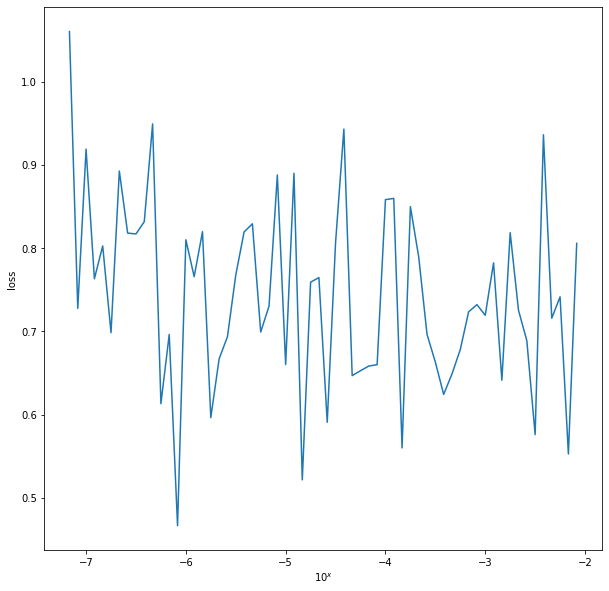

In [50]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [51]:
torch.cuda.empty_cache()

In [59]:
found_lr = 1e-4
found_lr

0.0001

### Learning ResNet by Differential Groups Layers

In [139]:
BATCH_SIZE

16

In [140]:
for param in model_resnet.parameters():
    param.requires_grad = True

In [141]:
params_to_update = print_learn_params(model_resnet)

Params to update:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2.3.bn1

In [142]:

loss_fn = nn.CrossEntropyLoss()
 
 
# Set different speed of training by the different layers
optimizer = torch.optim.Adam([
{ 'params': model_resnet.fc.parameters(), 'lr': found_lr},
{ 'params': model_resnet.layer4.parameters(), 'lr': found_lr / 3},
{ 'params': model_resnet.layer3.parameters(), 'lr': found_lr / 10},
{ 'params': model_resnet.layer2.parameters(), 'lr': found_lr / 50},
{ 'params': model_resnet.layer1.parameters(), 'lr': found_lr / 100},
{'params': model_resnet.bn1.parameters(), 'lr': found_lr / 100},
{'params': model_resnet.conv1.parameters(), 'lr': found_lr / 100}],
lr=found_lr / 100, amsgrad=True)
 
 
model_resnet= model_resnet.cuda()

### Start to train for the 10 epochs

In [143]:
# Path to save models.
path = '/content/gdrive/MyDrive/praha_0621/data/model'

In [329]:
model_resnet, losses, acc, best_model_wts = train_model(model_resnet, dataloaders, loss_fn, optimizer, num_epochs=10, flag_save_wts_to_file=True, path=path)

Logging...


Epoch 0/9 lr=[0.0001, 3.3333333333333335e-05, 1e-05, 2e-06, 1e-06, 1e-06, 1e-06]
----------
train Loss: 0.2945 Acc: 0.8679
val Loss: 0.3830 Acc: 0.8342

***new best wts with acc 0.8341968911917099 at 0 epoh***

***new best wts with loss 0.38301668181011717 at 0 epoh***
*** save model wts at this 0 epoch ! *** 

Epoch 1/9 lr=[0.0001, 3.3333333333333335e-05, 1e-05, 2e-06, 1e-06, 1e-06, 1e-06]
----------
train Loss: 0.2847 Acc: 0.8765
val Loss: 0.3334 Acc: 0.8860

***new best wts with acc 0.8860103626943006 at 1 epoh***

***new best wts with loss 0.3334447731133647 at 1 epoh***
*** save model wts at this 1 epoch ! *** 

Epoch 2/9 lr=[0.0001, 3.3333333333333335e-05, 1e-05, 2e-06, 1e-06, 1e-06, 1e-06]
----------
train Loss: 0.2669 Acc: 0.8875
val Loss: 0.3871 Acc: 0.8601
*** save model wts at this 2 epoch ! *** 

Epoch 3/9 lr=[0.0001, 3.3333333333333335e-05, 1e-05, 2e-06, 1e-06, 1e-06, 1e-06]
----------
train Loss: 0.2172 Acc: 0.9077
val Loss: 0.5188 Acc: 0.7772
*** save model wts at this 3

In [330]:
torch.cuda.empty_cache()

In [331]:
#load our best model
model_resnet.load_state_dict(torch.load(path + '_best_w_loss.pth'))


losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [332]:
# find Accuracy on validation dataset Accuracy: 0.886
print("Accuracy: {0:.4f}".format(evaluate(model_resnet, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.8860


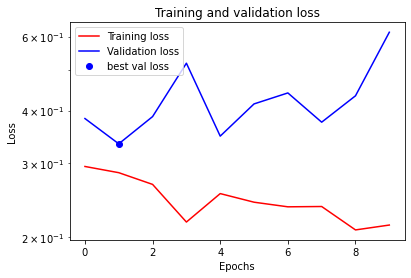

In [333]:
show_losses_plots(losses, smooth_flag = False, min = 0)

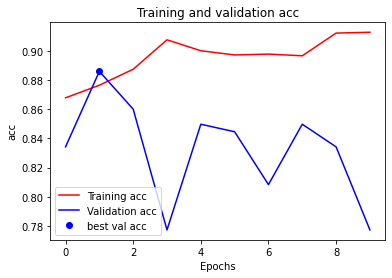

In [334]:
show_acc_plots(acc, smooth_flag = False)

Normalized confusion matrix


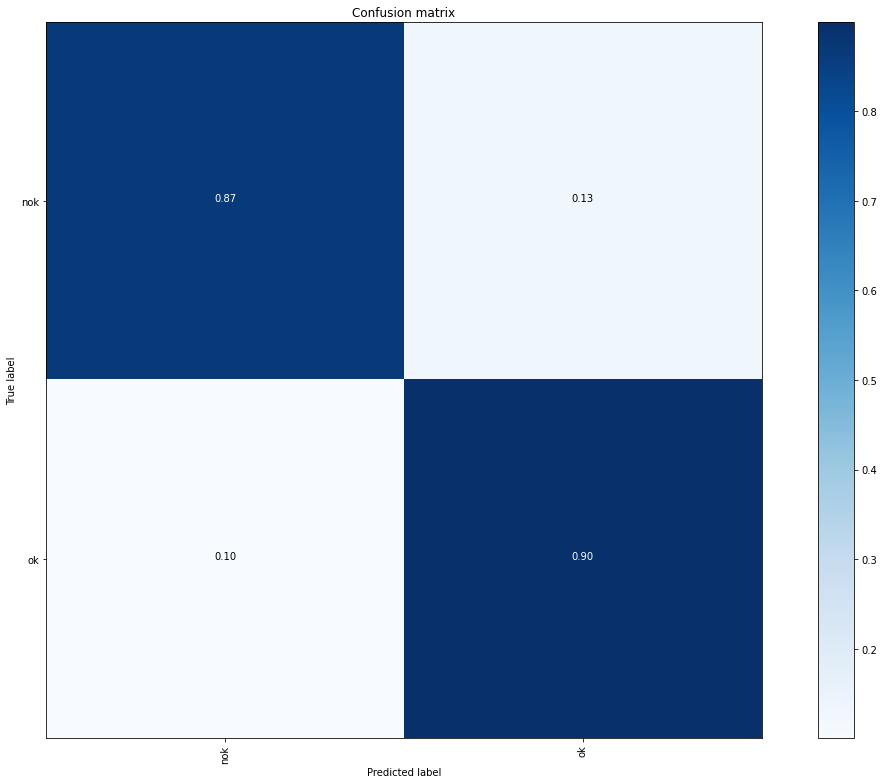

In [335]:

y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_resnet, dataloaders)

In [336]:
#validation dataset accuracy.
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[84, 109]
2
Accuracy of   nok	86 %
Accuracy of    ok	89 %


In [337]:
torch.cuda.empty_cache()

# Do the same for the test dataset

In [338]:
test_dataset_metrics = AppleDataset(test_files, mode='val')
dataloaders_test = {'val': DataLoader(test_dataset_metrics, batch_size=BATCH_SIZE, shuffle=False)}

In [339]:
# find Accuracy on test dataset Accuracy: 0.8465
print("Accuracy: {0:.4f}".format(evaluate(model_resnet, dataloaders_test['val'], DEVICE, use_gpu =True)))

Accuracy: 0.8465


Normalized confusion matrix


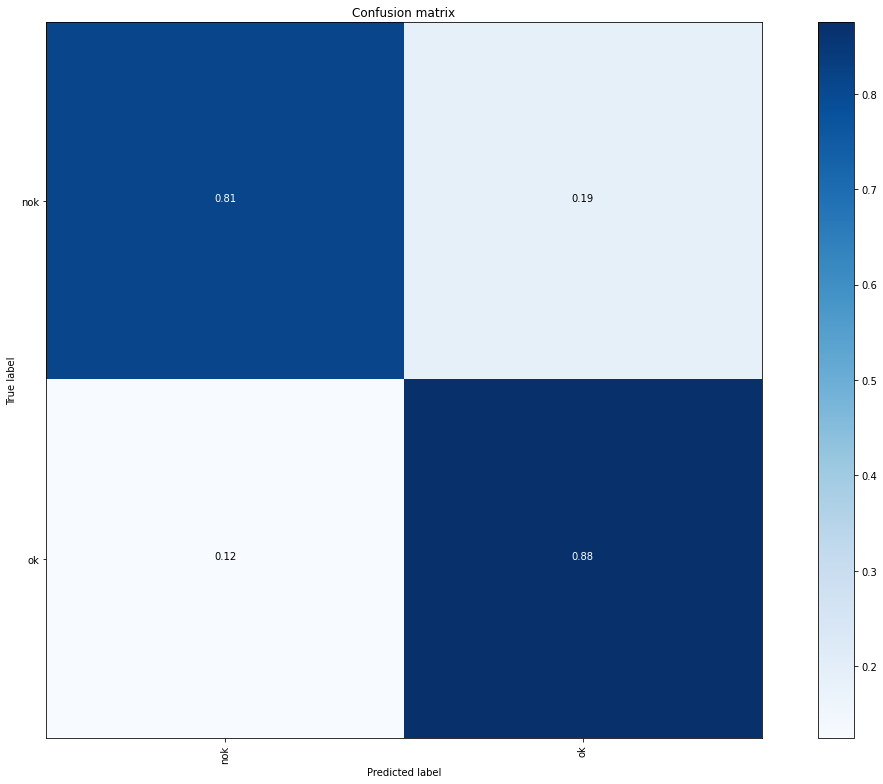

In [340]:

y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_resnet, dataloaders_test)

In [341]:
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[218, 264]
2
Accuracy of   nok	81 %
Accuracy of    ok	87 %


In [342]:
f1_score(y_test_all, predictions_all)

0.8619402985074627

## Save our model

In [345]:
path = '/content/gdrive/MyDrive/praha_0621/data/model/29_06_Final'
torch.save(model_resnet, path + 'Full_ResNet34_Last.pth')

# Next part xreate one class wrapper for the returning predictions.

In [346]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [348]:
import torch
import pickle
import numpy as np
import pandas as pd
 
from PIL import Image
 
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder

In [356]:
class DLModelImageClassifier(object):

    def __init__(self, path_model, path_label_enc):
        self.model = torch.load(path_model, map_location=torch.device('cpu'))
        self.model.eval()

        with open(path_label_enc, 'rb') as f:
            label_enc = pickle.load(f)
            
        self.label_enc = label_enc

        self.our_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)
    
    def transform_image(self, image_path):

        image = Image.open(image_path)

        return self.our_transforms(image).unsqueeze(0)

    def get_prediction(self, image_path):
        with torch.no_grad():
            tensor = self.transform_image(image_path=image_path)
            outputs = self.model.forward(tensor.to(self.device))
            _, prediction = torch.max(outputs, 1)
            prediction = prediction.cpu().detach().numpy()
        return self.label_enc.inverse_transform(prediction)[0]


In [357]:
# path to saved models.
path_model = '/content/gdrive/MyDrive/praha_0621/data/model/29_06_FinalFull_ResNet34_Last.pth'
# path to label encoder
path_label_enc = '/content/gdrive/MyDrive/praha_0621/data/model/label_encoder.pkl'

In [359]:
web_model = DLModelImageClassifier(path_model, path_label_enc)

In [362]:
#path to folder with the images which we need to predict.
import os
image_dump2 = os.listdir('/content/gdrive/MyDrive/praha_0621/data/exm5')

In [363]:
image_dump2[:4]

['1359.jpg', '628.jpg', '1636.jpg', '1889.jpg']

In [365]:
columns = ['id','label']
values_list = []
names_list = []
for elem in image_dump2:
  pred = web_model.get_prediction('/content/gdrive/MyDrive/praha_0621/data/exm5/' + elem)
  res = 'ok' if pred == 'ok' else 'nok'
  values_list.append(res)
  names_list.append(elem)

In [366]:
#create dataframe with and save final prediction to disk
results_df = pd.DataFrame(list(zip(names_list,values_list)),columns=columns)
results_df.to_csv('/content/gdrive/MyDrive/praha_0621/data/res.csv',index=False)

In [367]:
results_df.head(15)

,id,label
0,1359.jpg,nok
1,628.jpg,nok
2,1636.jpg,nok
3,1889.jpg,nok
4,2144.jpg,ok
5,826.jpg,ok
6,1572.jpg,nok
7,984.jpg,ok
8,2769.jpg,ok
9,889.jpg,ok
